In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import fft
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import butter, filtfilt
from scipy.signal import find_peaks

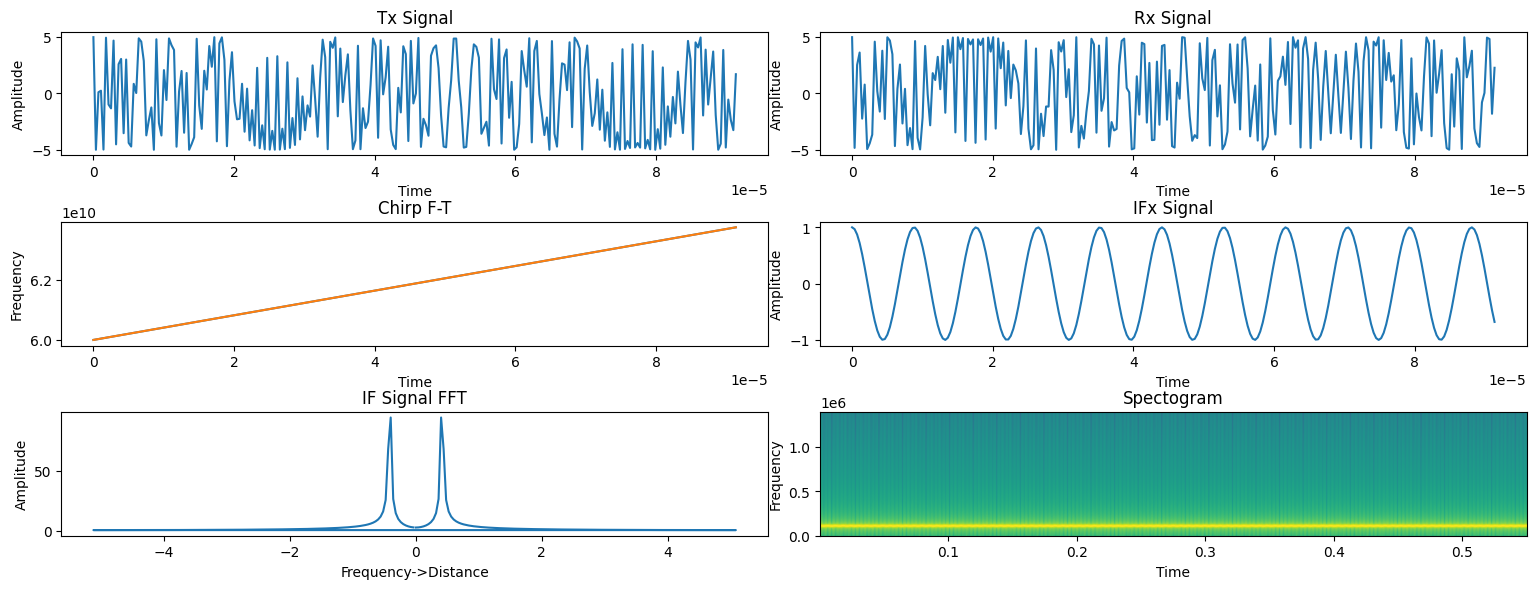

In [13]:
#Radar parameters setting
TARGET_DISTANCE =0.4

maxR = 11 #Maximum range in meter
maxV = 70 
fc = 60e9 #Carrier frequency
c = 3e8 # speed of light

v0 = 0 #target velocity
FPS=20# 20 frame per second
duration = 300  # Duration in seconds
CPF=1# 2 chirp per frame
Nd = duration * FPS * CPF# number of chirps
Nr = 256 #number of sample per chirp


NUM_SAMPLE_PER_MINUTE=60 * FPS * CPF

B=3.75 * (1e9) #Bandwidth
rangeRes = c/(2*B) #Range resolution

Tchirp = 91.72 * (1e-6) #time of chirp or chirp duration
slope = B/Tchirp 

t0 = np.linspace(0,Tchirp,Nr,endpoint=False)  #sai cho time chirp
t=np.tile(t0,Nd)
t=t.flatten()

r0 = np.ones(len(t)) #target distance
r0[:len(t)//2] =TARGET_DISTANCE
r0[len(t)//2:] =TARGET_DISTANCE

Fs = Nr/Tchirp  #Sampling rate

amplitude_TX=5
amplitude_RX=5

angle_freq = fc*t+(slope*t*t)/2 
freq = fc + slope*t 
Tx = amplitude_TX *np.cos(2*np.pi*angle_freq)

plt.figure(figsize=(16,8))

plt.subplot(4,2,1)
plt.plot(t[0:Nr],Tx[0:Nr])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Tx Signal')
plt.subplot(4,2,3)
plt.plot(t[0:Nr],freq[0:Nr])
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Tx F-T')
# target setting
r0 = r0+v0*t # target distance with velocity is 0
td = 2*r0/c #time delay
tx = t
freqRx = fc + slope*(t)

breathing_freq = 0.3  # Frequency in Hz
heart_freq = 2  # Frequency in Hz
vibration_amplitude_breath = 0.004  # Amplitude of the signal
vibration_amplitude_heart = 0.001  # Amplitude of the signal

sampling_rate = FPS*Nr *CPF # Sampling rate in Hz of heart and breath = (frame per second) * (chirp per frame) * (sample per frame)

# Time array
breath_time = np.arange(0, duration, 1 / sampling_rate)
heart_time = np.arange(0, duration, 1 / sampling_rate)

# Calculate target vibration displacement profile (using a sinusoidal function for breathing-like motion)
vibration_displacement_breath = vibration_amplitude_breath * np.sin(2 * np.pi * breathing_freq * breath_time)
vibration_displacement_heart = vibration_amplitude_heart * np.sin(2 * np.pi * heart_freq * heart_time)
breath_heart_vibration_displacement  = vibration_displacement_breath + vibration_displacement_heart
td = 2*(r0+breath_heart_vibration_displacement)/c
# Calculate the phase shift for the vibration effect in received signal
Rx = amplitude_RX *np.cos(2*np.pi*(fc*(t-td) + (slope*(t-td)*(t-td))/2)) 

plt.subplot(4,2,2)
plt.plot(t[0:Nr],Rx[0:Nr])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Rx Signal')
plt.subplot(4,2,3)
plt.plot(t[0:Nr]+td[0:Nr],freqRx[0:Nr])
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Chirp F-T')

IFx = np.cos(-(2*np.pi*(fc*(t-td) + (slope*(t-td)*(t-td))/2))+(2*np.pi*angle_freq))

plt.subplot(4,2,4)
plt.plot(t[0:Nr],IFx[0:Nr])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('IFx Signal')

#Range FFT

doppler = np.abs(np.fft.fft(IFx[0:Nr]))
frequency = np.fft.fftfreq(Nr, 1/Fs)
range_freq = frequency*c/(2*slope)
plt.subplot(4,2,5)
plt.plot(range_freq[0:Nr],doppler[0:Nr])
plt.xlabel('Frequency->Distance')
plt.ylabel('Amplitude')
plt.title('IF Signal FFT')

#2D plot
plt.subplot(4,2,6)
plt.specgram(IFx,Nr,Fs)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Spectogram')

plt.tight_layout(pad=3, w_pad=0.05, h_pad=0.05)
plt.show()

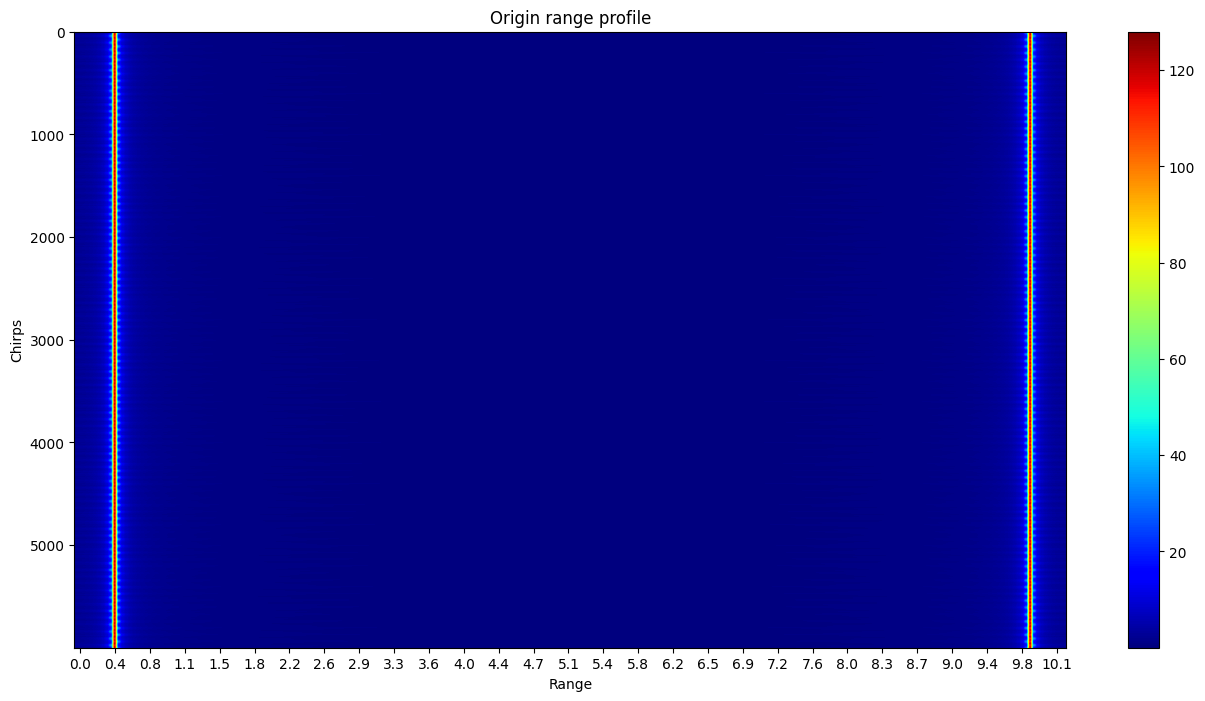

In [7]:
IFMatrix =IFx.reshape(Nd,Nr)
rangeProfiles =np.fft.fft (IFMatrix,axis=1)
magnitude_range_profile = [np.abs(profile) for profile in rangeProfiles]
range_fre = frequency*c/(2*slope)
rangeBinDistance = [round(j*rangeRes,1) for j in range(1,Nr,9) ]

plt.figure(figsize=(16,8))
plt.xlabel('Range')
plt.ylabel('Chirps')
plt.imshow(magnitude_range_profile,aspect='auto',cmap='jet')
plt.colorbar()
plt.xticks(range(1,Nr,9), rangeBinDistance)
plt.title("Origin range profile")
plt.show()


In [8]:
#find the bin with the highest magnitude 
magnitude_range_profile_shape =np.array(magnitude_range_profile).shape
max_indices =[0]*magnitude_range_profile_shape[0]
for mag_profile in magnitude_range_profile:
    max_index = np.argmax(mag_profile)
    max_indices[max_index]+=1
interesting_bin =np.argmax(max_indices)
print(interesting_bin)
print("target at bin :{0}th, distance: {1}m".format(interesting_bin,interesting_bin* rangeRes))

10
target at bin :10th, distance: 0.4m


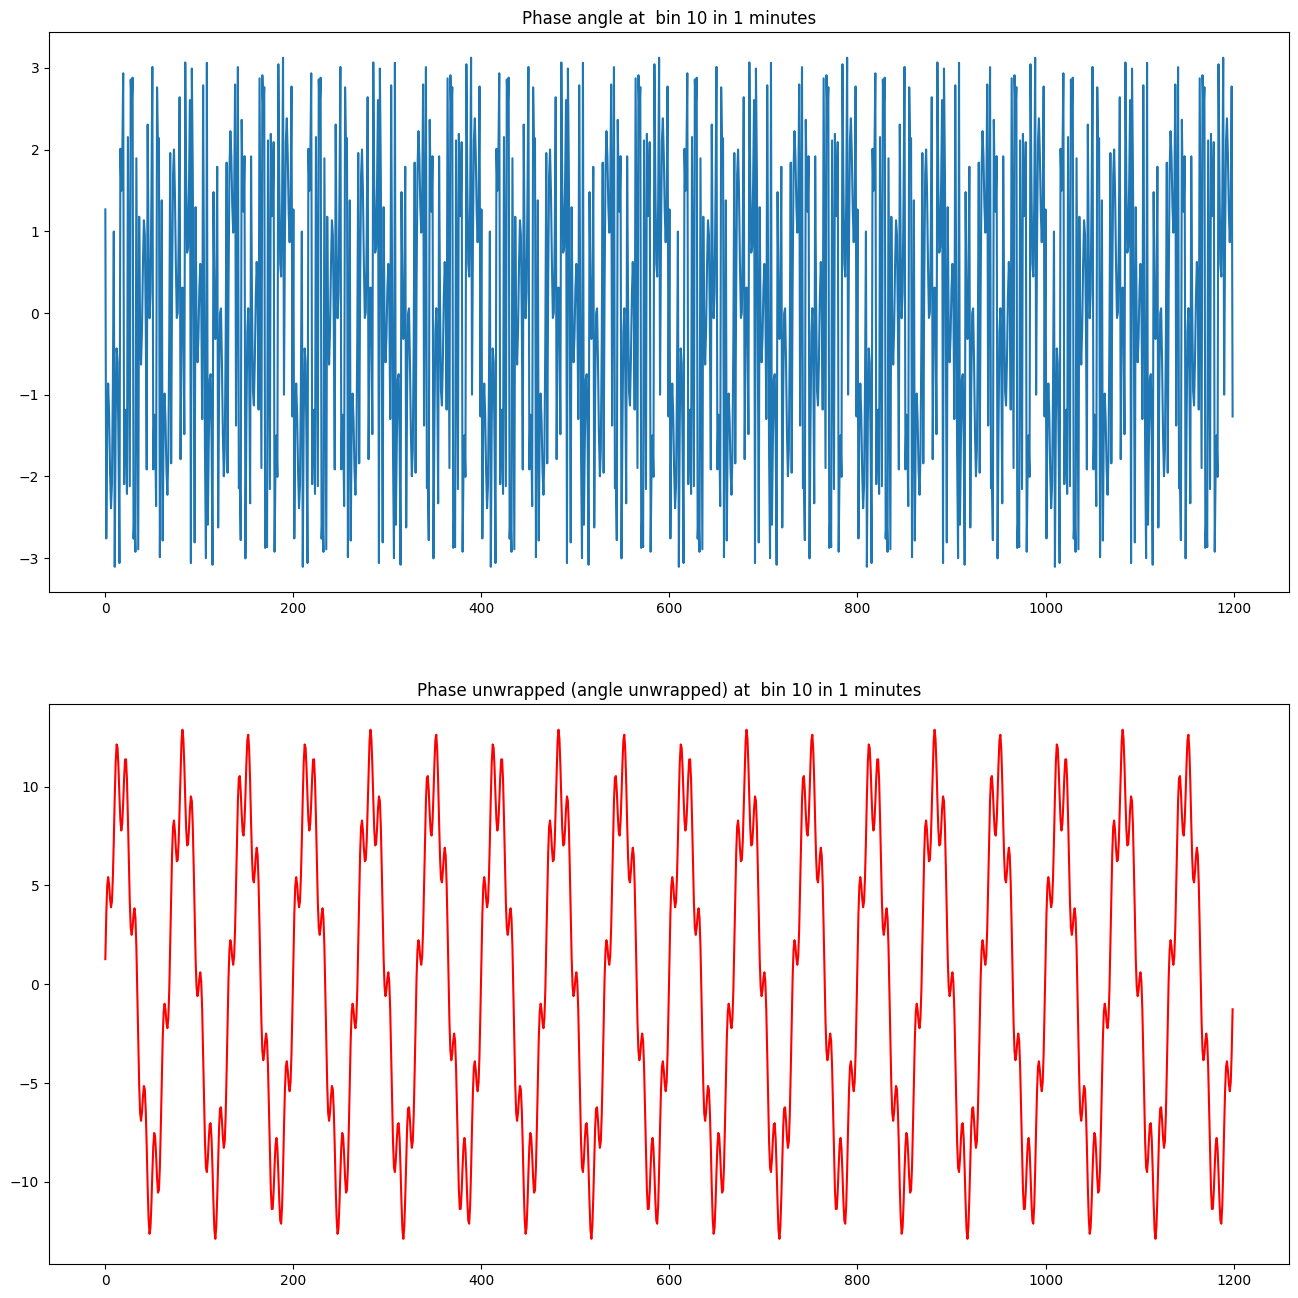

In [14]:
interest_bin_phase = np.array(rangeProfiles)[:,interesting_bin]
phase_angle =np.angle(interest_bin_phase)
phase_angle_unwrapped = np.unwrap(phase_angle)

plt.figure(figsize=(16,16))

plt.subplot(211)
plt.plot(phase_angle[:NUM_SAMPLE_PER_MINUTE])
plt.title("Phase angle at  bin {0} in 1 minutes".format(interesting_bin))

plt.subplot(212)
plt.plot(phase_angle_unwrapped[:NUM_SAMPLE_PER_MINUTE],color="red")
plt.title("Phase unwrapped (angle unwrapped) at  bin {0} in 1 minutes".format(interesting_bin))

plt.show()

/Users/truongdinh/Downloads/Children Dataset/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


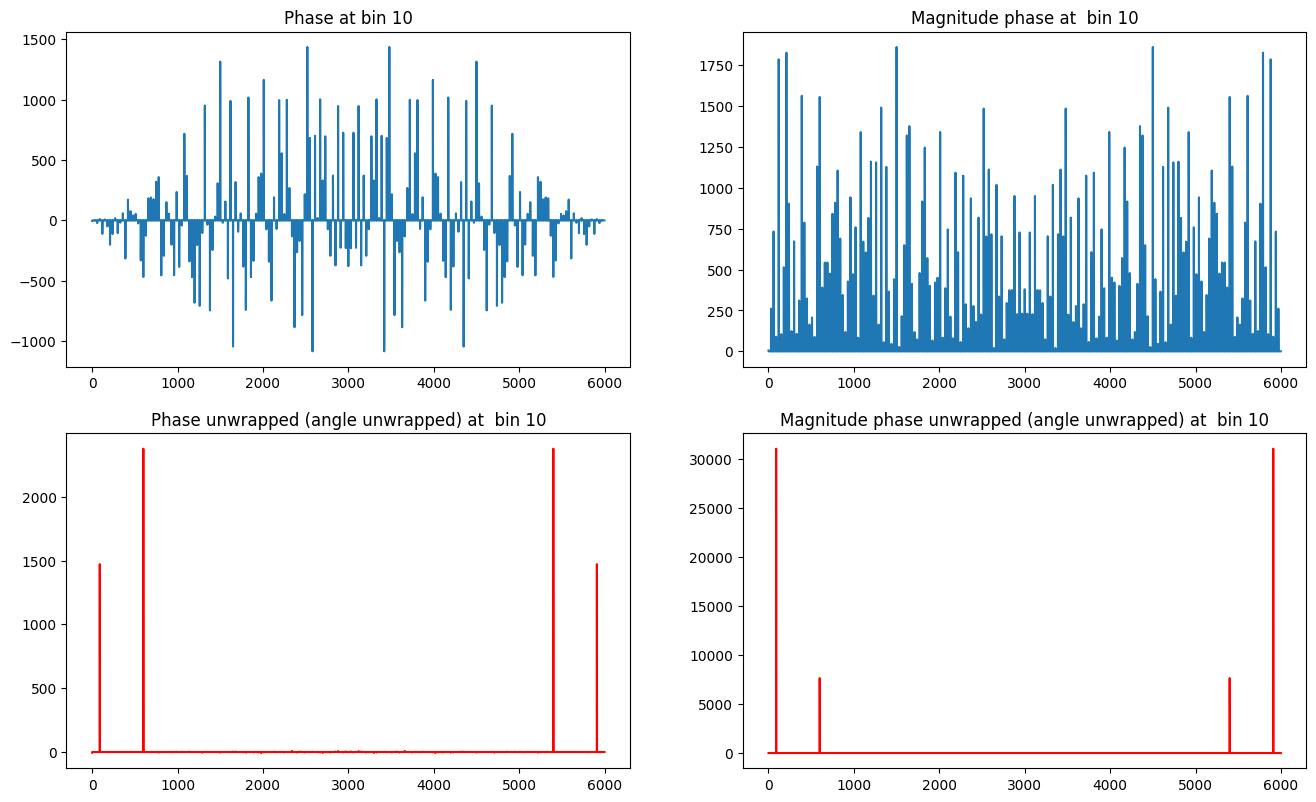

In [35]:

plt.figure(figsize=(16,20))

plt.subplot(421)
plt.plot((np.fft.fft(phase_angle)))
plt.title("Phase at bin {0}".format(interesting_bin))

plt.subplot(422)
plt.plot(np.abs(np.fft.fft(phase_angle)))
plt.title("Magnitude phase at  bin {0}".format(interesting_bin))

plt.subplot(423)
plt.plot((np.fft.fft(phase_angle_unwrapped)),color="red")
plt.title("Phase unwrapped (angle unwrapped) at  bin {0}".format(interesting_bin))

plt.subplot(424)
plt.plot(np.abs(np.fft.fft(phase_angle_unwrapped)),color="red")
plt.title("Magnitude phase unwrapped (angle unwrapped) at  bin {0}".format(interesting_bin))

plt.show()


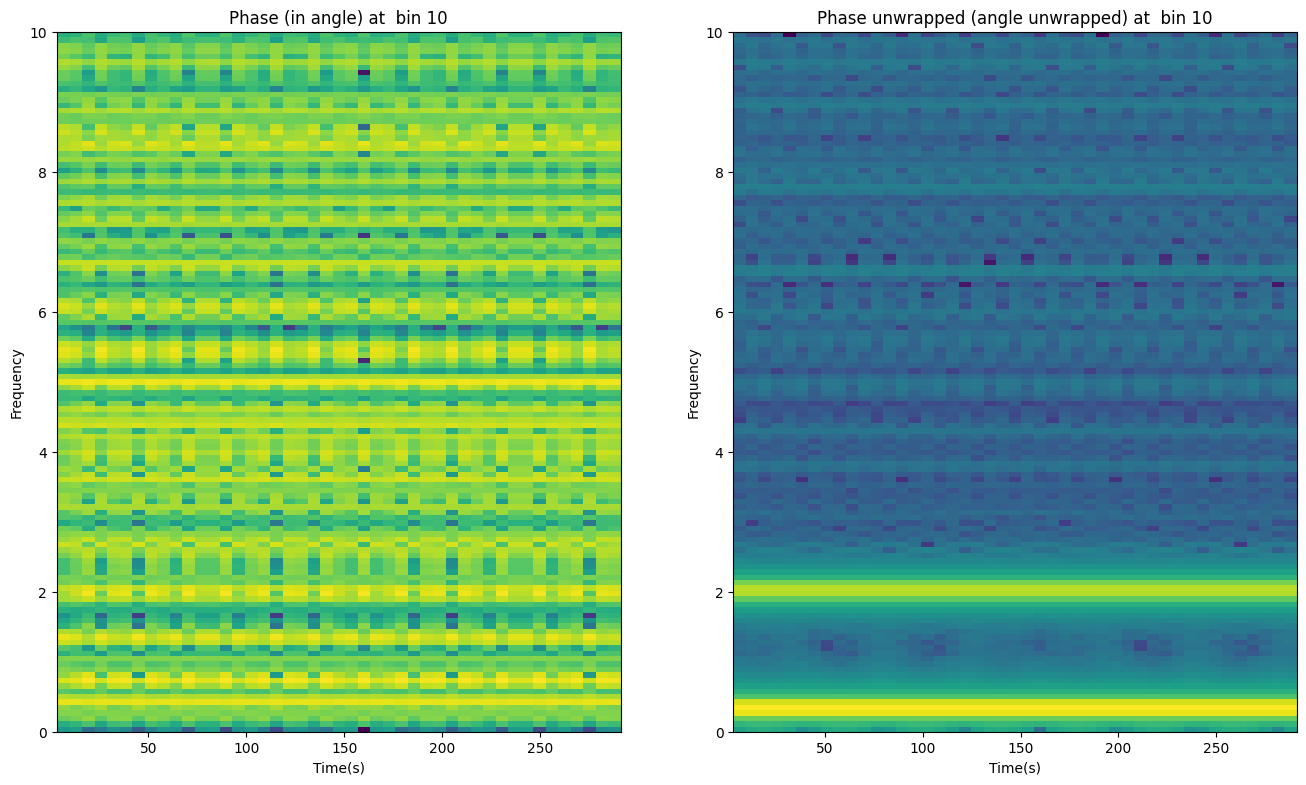

In [67]:
plt.figure(figsize=(16,20))

plt.subplot(221)
plt.specgram(phase_angle,Fs=20)
plt.title("Phase (in angle) at  bin {0}".format(interesting_bin))
plt.xlabel("Time(s)")
plt.ylabel("Frequency")

plt.subplot(222)
plt.specgram(phase_angle_unwrapped,Fs=20)
plt.title("Phase unwrapped (angle unwrapped) at  bin {0}".format(interesting_bin))
plt.xlabel("Time(s)")
plt.ylabel("Frequency")

plt.show()

In [37]:
def filter_signal (signal_to_filter ,_low_freq,_high_freq,_sampling_rate,_filter_order):
    sampling_rate = _sampling_rate# Sampling rate of the input signal
    low_freq = _low_freq  # Lower cutoff frequency of the bandpass filter
    high_freq = _high_freq  # Upper cutoff frequency of the bandpass filter
    filter_order = _filter_order # Order of the bandpass filter

    # Compute the normalized cutoff frequencies
    nyquist_freq = 0.5 * sampling_rate
    low_norm = low_freq / nyquist_freq
    high_norm = high_freq / nyquist_freq
    
    # Design the bandpass filter
    b, a = butter(filter_order, [low_norm, high_norm], btype='band')

    # Apply the bandpass filter to the input signal
    signal_filtered = filtfilt(b, a, signal_to_filter)
    return signal_filtered

In [108]:
SR=FPS*CPF #there are (FPS frame * CPF chirp) per second, each frame we get one sample 

breath_heart_band_filtering=[0.1,5]
filtered_signal =filter_signal(np.array(phase_angle_unwrapped),breath_heart_band_filtering[0],breath_heart_band_filtering[1],SR,4)

breath_band_filtering=[0.3,0.6]
breath_filtered_signal =filter_signal(np.array(phase_angle_unwrapped),breath_band_filtering[0],breath_band_filtering[1],SR,4)

heart_band_filtering=[2,6]
heart_filtered_signal =filter_signal(np.array(phase_angle_unwrapped),heart_band_filtering[0],heart_band_filtering[1],SR,4)

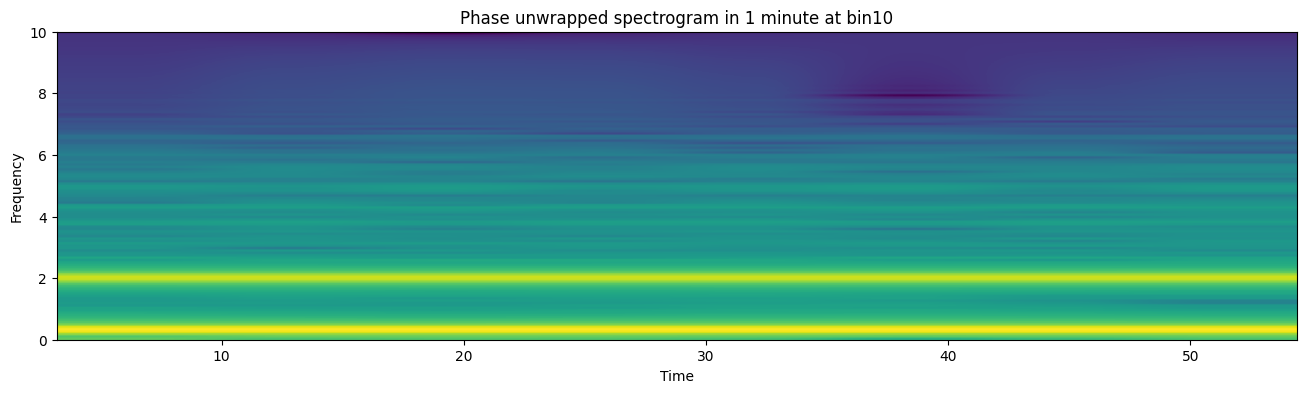

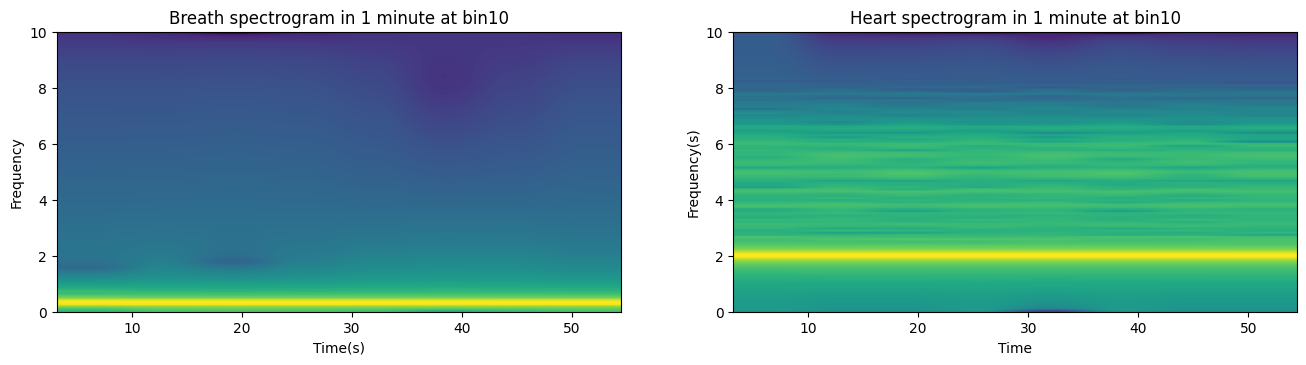

In [109]:
plt.figure(figsize=(16,4))
plt.specgram(filtered_signal[:1200],Fs=SR)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.title("Phase unwrapped spectrogram in 1 minute at bin{0}".format(interesting_bin))
plt.show()

plt.figure(figsize=(16,8))
plt.subplot(221)
plt.specgram(breath_filtered_signal[:1200],Fs=SR)
plt.xlabel("Time(s)")
plt.ylabel("Frequency")
plt.title("Breath spectrogram in 1 minute at bin{0}".format(interesting_bin))

plt.subplot(222)
plt.specgram(heart_filtered_signal[:1200],Fs=SR)
plt.xlabel("Time")
plt.ylabel("Frequency(s)")
plt.title("Heart spectrogram in 1 minute at bin{0}".format(interesting_bin))

plt.show()

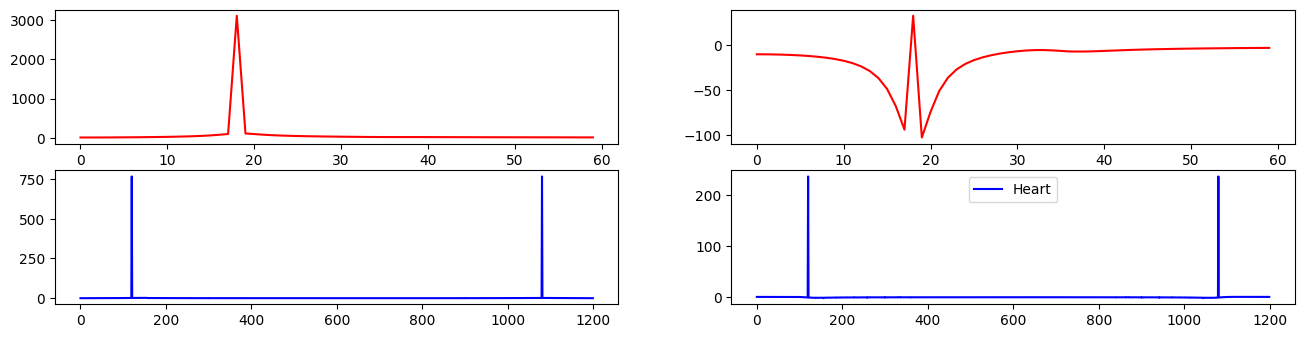

In [110]:
plt.figure(figsize=(16,8))
plt.subplot(421)
plt.plot(np.abs(np.fft.fft(breath_filtered_signal[:NUM_SAMPLE_PER_MINUTE]))[:60],color="red",label="Breath")
plt.subplot(422)
plt.plot((np.fft.fft(breath_filtered_signal[:NUM_SAMPLE_PER_MINUTE]))[:60],color="red",label="Breath")
plt.subplot(423)
plt.plot(np.abs(np.fft.fft(heart_filtered_signal[:NUM_SAMPLE_PER_MINUTE])),color="blue",label="Heart")
plt.subplot(424)
plt.plot((np.fft.fft(heart_filtered_signal[:NUM_SAMPLE_PER_MINUTE])),color="blue",label="Heart")
plt.legend()
plt.show()


In [119]:
def getFreq(theSignal,signalSamplingRate,windowSize,overlapSize):
    freqs=[]
    num_windows = (len(theSignal) - windowSize) // overlapSize + 1
    
    for i in range(num_windows):
        start_index = i * overlapSize
        end_index = start_index + windowSize
        window = theSignal[start_index:end_index]

        fft_output=np.fft.fft(window)
        freq_axis =np.fft.fftfreq(len(window), 1/signalSamplingRate)
        sorted_indices = (np.argsort(np.abs(fft_output))[::-1])[:1]
        
        freqs.append((abs(freq_axis[sorted_indices]))[0])
    return freqs

    

[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]
[120.]

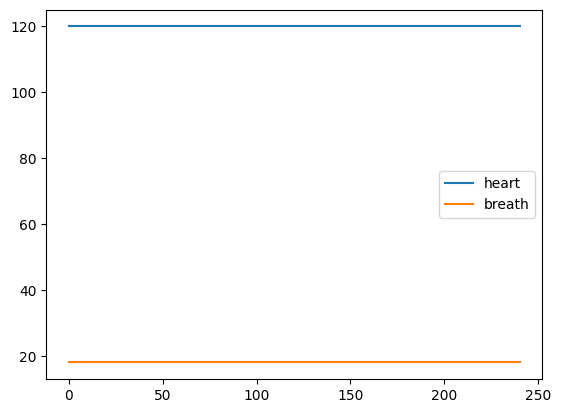

In [121]:
heartfreqs =getFreq(heart_filtered_signal,60*FPS*CPF,NUM_SAMPLE_PER_MINUTE,20)
breathfreqs =getFreq(breath_filtered_signal,60*FPS*CPF,NUM_SAMPLE_PER_MINUTE,20)
plt.plot(heartfreqs,label="heart")
plt.plot(breathfreqs,label="breath")
plt.legend()
plt.show()

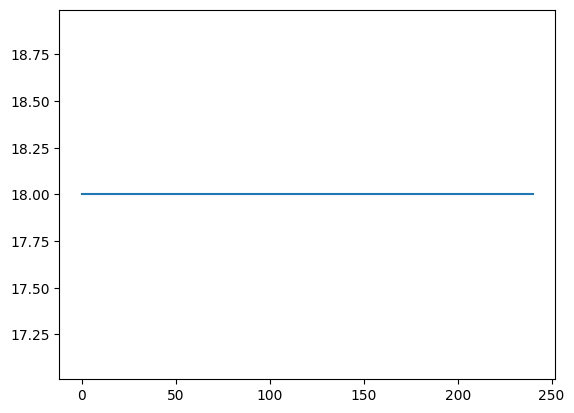

In [118]:
heart_freq=[]
window_size = 1200
overlap = 20

num_windows = (len(breath_filtered_signal) - window_size) // overlap + 1

for i in range(num_windows):
    start_index = i * overlap
    end_index = start_index + window_size
    window = breath_filtered_signal[start_index:end_index]

    heart_mag =np.abs(np.fft.fft(window))
    heart_peak = np.argmax(heart_mag)
    frequencies = np.fft.fftfreq(len(window),1/(60*FPS*CPF))
    heart_freq.append(np.abs(frequencies[heart_peak]))
    
plt.plot(heart_freq)
plt.show()
    